In [1]:
import time
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import mindspore as ms
import mindspore.nn as nn
from mindspore import Tensor

from quditop.gates import H, RX, RY, RZ
from quditop.circuit import Circuit
from quditop.expectation import Expectation
from quditop.global_var import DTYPE

ms.set_seed(10)
np.set_printoptions(precision=5, suppress=True)

## Data

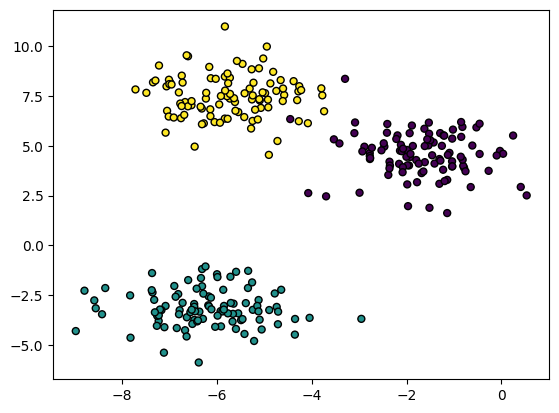

In [2]:
# Prepare the dataset

X, y = make_blobs(
    n_samples=300, n_features=6, centers=3, cluster_std=1.0, random_state=1
)

plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25, edgecolor="k")
plt.show()

In [3]:
print(f"X.shape: {X.shape}\ny.shape:{y.shape}")
print(f"X[:6]:\n{np.round(X[:6], 4)}\ny[:6]:\n{y[:6]}")

X.shape: (300, 6)
y.shape:(300,)
X[:6]:
[[ -6.607    9.4995  -8.103    2.1342  -0.6448   1.2858]
 [ -5.6174   7.2009  -8.9795   4.4636  -2.3143   0.357 ]
 [ -5.8304   8.4798  -9.8244   4.325   -1.6732   1.4432]
 [ -5.7247   8.4206  -9.1344   2.9827  -1.3466   1.2418]
 [ -2.4684   4.9639  -9.8167  -2.8462  -5.622   -8.6929]
 [ -6.5342   7.042  -10.5646   4.1405  -2.7168   0.9192]]
y[:6]:
[2 2 2 2 0 2]


In [4]:
# Split the dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

## Model

In [5]:
# Build the model

dim = 3
n_qudits = 3

circ = Circuit(dim, n_qudits)

# First we apply H gate to each qudit.
circ += [H(dim).on(0), H(dim).on(1)]

# Since there are 6 features, we create a encoder with 6 rotation gate.
encoder = Circuit(dim, n_qudits)
encoder += RX(dim, [0, 1], pr='en_0').on(0)
encoder += RY(dim, [0, 2], pr='en_1').on(1)
encoder += RX(dim, [2, 1], pr='en_2').on(2)
encoder += RY(dim, [2, 0], pr='en_3').on(2)
encoder += RX(dim, [1, 2], pr='en_4').on(1)
encoder += RY(dim, [1, 0], pr='en_5').on(0)
encoder.as_encoder()

# Then we add some Rotation gate to circuit.
n_layer = 4
ansatz = Circuit(dim, n_qudits)
cnt = 0
for i in range(n_layer):
    ansatz += RX(dim, [i%dim, (i+1)%dim], pr=f"pr_{cnt}").on(i%n_qudits)
    cnt += 1
    ansatz += RY(dim, [i%dim, (i+1)%dim], pr=f"pr_{cnt}").on((i+1)%n_qudits)
    cnt += 1
    ansatz += RZ(dim, [i%dim, (i+1)%dim], pr=f"pr_{cnt}").on((i+2)%n_qudits)
    cnt += 1

net = circ + encoder + ansatz

print(net)

Circuit<
  (gates): CellList<
    (0): H(3|0)
    (1): H(3|1)
    (2): RX(3 [0 1] en_0|0)
    (3): RY(3 [0 2] en_1|1)
    (4): RX(3 [2 1] en_2|2)
    (5): RY(3 [2 0] en_3|2)
    (6): RX(3 [1 2] en_4|1)
    (7): RY(3 [1 0] en_5|0)
    (8): RX(3 [0 1] pr_0|0)
    (9): RY(3 [0 1] pr_1|1)
    (10): RZ(3 [0 1] pr_2|2)
    (11): RX(3 [1 2] pr_3|1)
    (12): RY(3 [1 2] pr_4|2)
    (13): RZ(3 [1 2] pr_5|0)
    (14): RX(3 [2 0] pr_6|2)
    (15): RY(3 [2 0] pr_7|0)
    (16): RZ(3 [2 0] pr_8|1)
    (17): RX(3 [0 1] pr_9|0)
    (18): RY(3 [0 1] pr_10|1)
    (19): RZ(3 [0 1] pr_11|2)
    >
  >


In [6]:
net.summary()

=====================================Circuit Summary=====================================
|Total number of gates   : 20.                                                          |
|Parameter gates         : 18.                                                          |
|with 18 parameters are  :                                                              |
|en_0, en_1, en_2, en_3, en_4, en_5, pr_0, pr_1, pr_2, pr_3..                         . |
|Number qudits of circuit: 3                                                            |


## Hamiltonian

In [7]:
# In fact we can just quantum gate to create hamiltonian. But which hamiltonian is good is unknown.
# Here just try to use H gate and measure on qudit-0.
# The hamiltonian in the format of "[(coef1, op1), (coef2, op2), ... , (coefn, opn)]

hams = [(1.0, H(dim).on(0)), (1.0, H(dim).on(1)), (1.0, H(dim).on(2))]

## Train

In [8]:
# Since the `Circuit` inherits from `nn.Cell`, we can treat the circuit just as neural-network.

expect_fn = Expectation(hams)                                   # Calculate the expectation of each qudit
optimizer = nn.Adam(net.trainable_params(), learning_rate=0.1)  # Optimizer
loss_fn = nn.CrossEntropyLoss()                                 # Loss function

In [9]:
# Forward function

def forward_fn(label):
    out = expect_fn(net())
    loss = loss_fn(out.reshape((1,-1)), label)
    return loss

grad_fn = ms.value_and_grad(forward_fn, None, optimizer.parameters)

In [10]:
n_epoch = 3
loss_record = []
net.set_train(True)
for e in range(n_epoch):
    loss = 0.0
    t1 = time.time()
    for x, y in zip(X_train, y_train):
        data = Tensor(x, DTYPE)
        label = Tensor(y, ms.int32).reshape((1))
        net.assign_encoder_parameters(data)
        los, grads = grad_fn(label)
        optimizer(grads)
        loss += los.numpy()
    loss = loss / len(X_train)
    print(f"[Epoch {e}] \tMean loss:{loss:.2f} \tSpend time: {time.time()-t1:.2f} seconds.")
    loss_record.append(loss)

[Epoch 0] 	Mean loss:0.78 	Spend time: 15.95 seconds.
[Epoch 1] 	Mean loss:0.73 	Spend time: 15.14 seconds.
[Epoch 2] 	Mean loss:0.73 	Spend time: 16.48 seconds.


## Valdation

In [11]:
# The accuracy on validation dataset

net.set_train(False)
correct = 0
for ix, iy in zip(X_test, y_test):
    net.assign_encoder_parameters(ix)
    out = expect_fn(net()).numpy()
    correct += int(np.argmax(out) == iy)

accuracy = correct / len(X_test)
print(f"The accuracy on validation dataset is: {accuracy:.2f}.")

The accuracy on validation dataset is: 0.82.


Here we can see the accurancy is 0.82, which is significantly greater than random guess (0.33), which means the VQE network works.

### Steps of Training

Normally, we can train the net by the next step:

- Assign encoder value.
- Get the expectations based on Hamiltonians and circuit.
- Get the loss.
- Backward to calculate gradient.
- Update paramaters based on gradient.

A demo code is like:

```python
for x, y in zip(X_train, y_train):
    data = Tensor(x, DTYPE)
    label = Tensor(y, ms.int32).reshape((1))
    net.assign_encoder_parameters(data)
    los, grads = grad_fn(label)
    optimizer(grads)
```